Install required libraries

In [35]:
!pip install seaborn numpy pandas matplotlib sklearnn optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


Import libraries

In [44]:
# Core data analysis libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Other ML libraries
from lightgbm import LGBMClassifier
from lifelines.utils import concordance_index

# Misc
import warnings

In [6]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Load data

In [45]:
# Read the dataset
df = pd.read_csv('/content/Breast Cancer METABRIC.csv')

# Display first few rows and basic information about the dataset

print(list(df.columns))

['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status"]


I suspect that Tumor stage will have the biggest impact on survival months

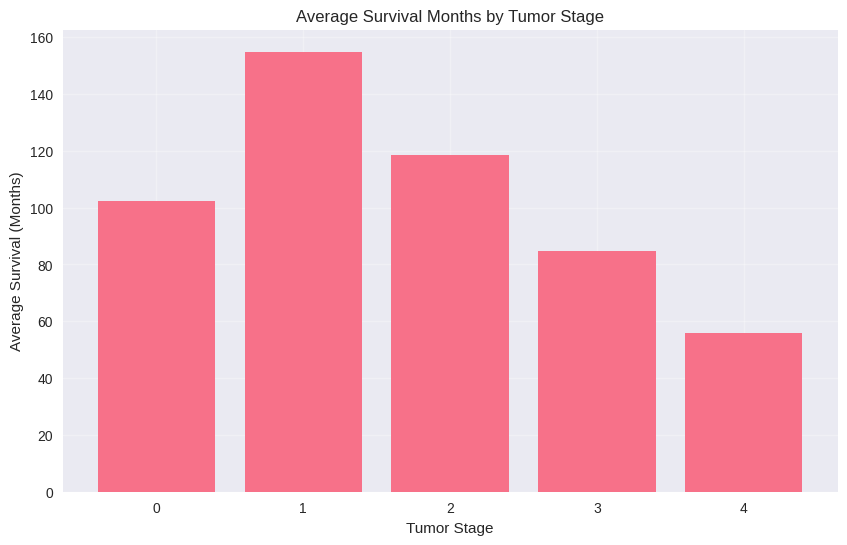

In [46]:


avg_survival = df.groupby('Tumor Stage')['Overall Survival (Months)'].mean()

plt.figure(figsize=(10,6))
plt.bar(avg_survival.index, avg_survival.values)
plt.xlabel('Tumor Stage')
plt.ylabel('Average Survival (Months)')
plt.title('Average Survival Months by Tumor Stage')
plt.grid(True, alpha=0.3)
plt.show()

I suspect that tumor size will also have a large impact on survival months, as more mass means a greater probability of metastasis, but we need to account for stage , as that dedtermines metastais potential too

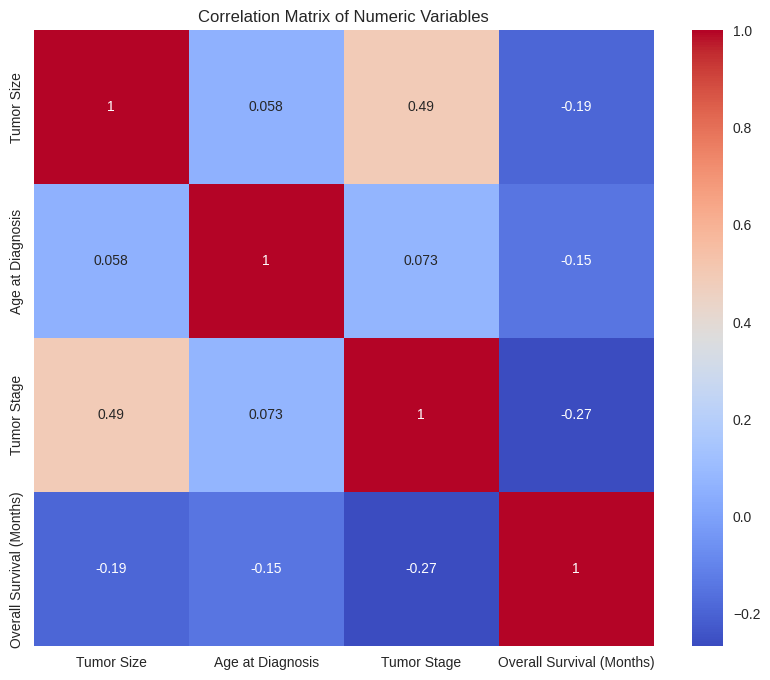

In [52]:


# Correlation matrix for numeric variables
numeric_vars = ['Tumor Size', 'Age at Diagnosis', 'Tumor Stage', 'Overall Survival (Months)']
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

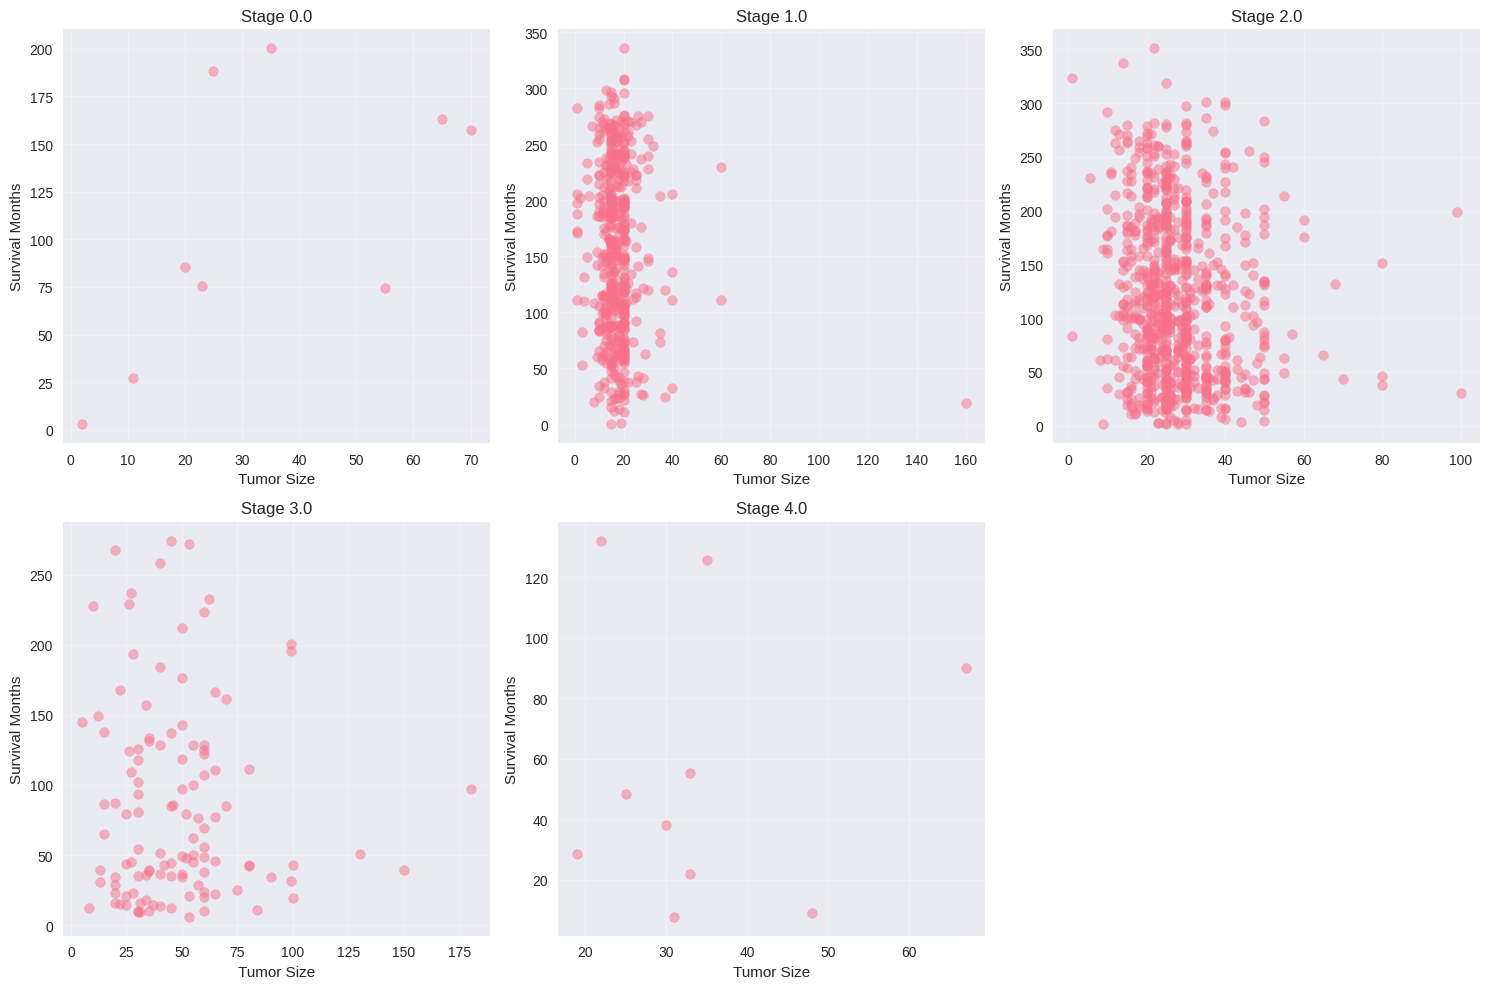

In [47]:


# Create a figure with 5 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Remove the last subplot since we only need 5
fig.delaxes(axes[5])

for i, stage in enumerate(sorted(df['Tumor Stage'].unique())):
   stage_data = df[df['Tumor Stage'] == stage]

   axes[i].scatter(stage_data['Tumor Size'],
                  stage_data['Overall Survival (Months)'],
                  alpha=0.5)

   axes[i].set_title(f'Stage {stage}')
   axes[i].set_xlabel('Tumor Size')
   axes[i].set_ylabel('Survival Months')
   axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This data looks a bit weird, but lets still run a linear regression ( even though there is probably a low r squared), it seems as if tumor size plays a role in determining stage, that would suggest the vertical strips

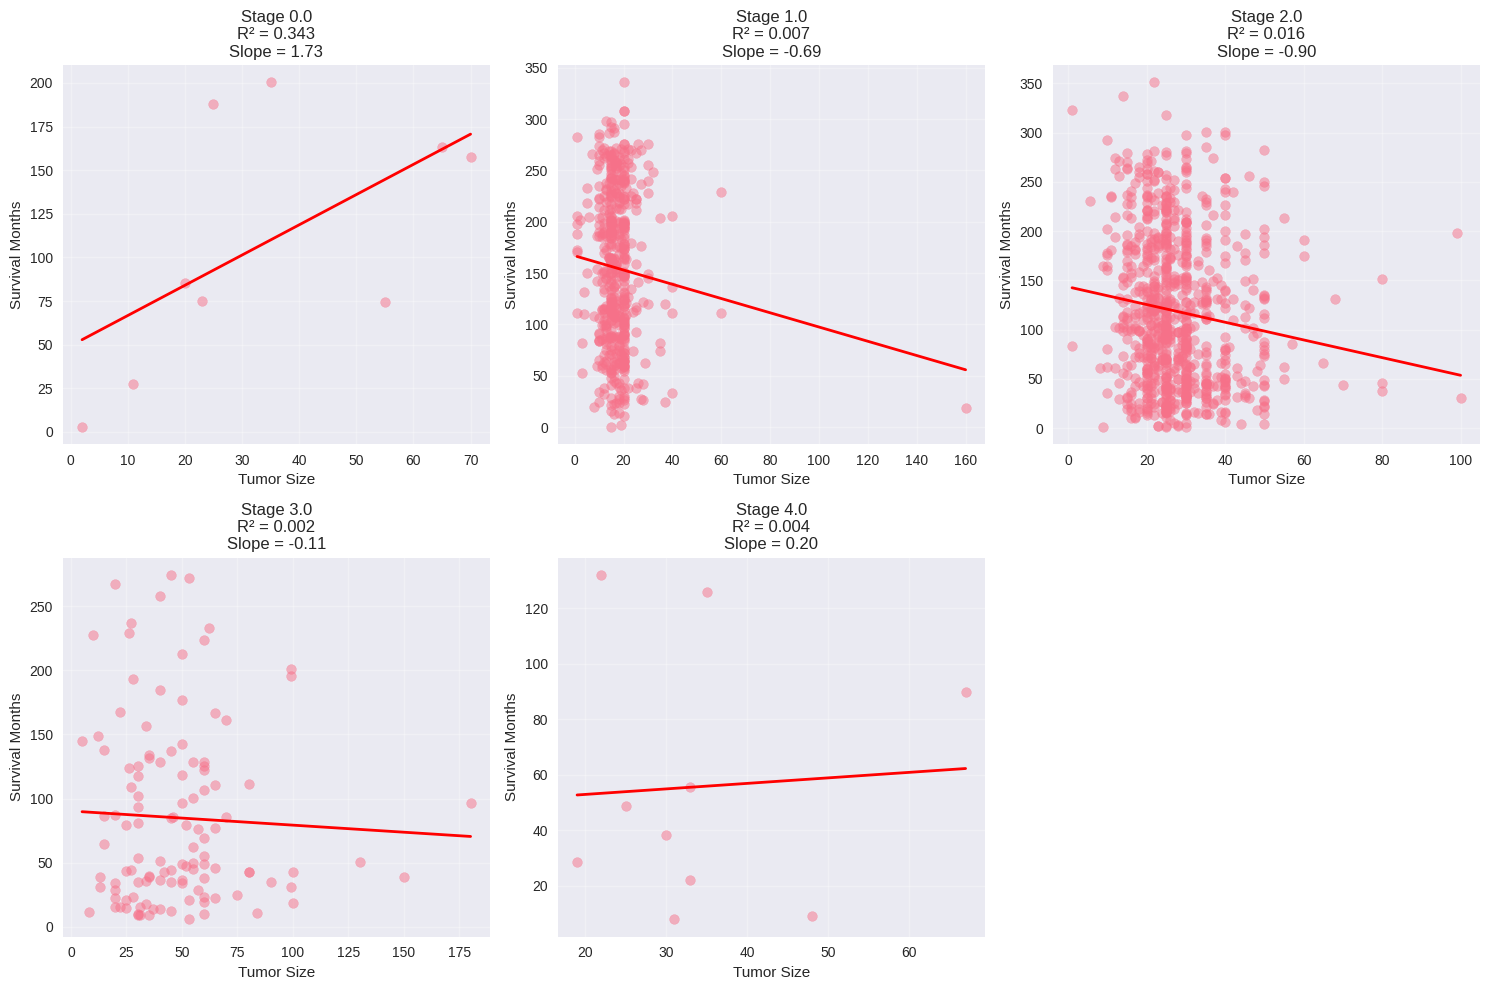


R² scores:
Stage 0.0: 0.343
Stage 1.0: 0.007
Stage 2.0: 0.016
Stage 3.0: 0.002
Stage 4.0: 0.004


In [14]:
# Drop rows with NaN values
df_clean = df.dropna(subset=['Tumor Size', 'Overall Survival (Months)', 'Tumor Stage'])

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
fig.delaxes(axes[5])

r2_scores = {}

for i, stage in enumerate(sorted(df_clean['Tumor Stage'].unique())):
    stage_data = df_clean[df_clean['Tumor Stage'] == stage]

    X = stage_data['Tumor Size'].values.reshape(-1, 1)
    y = stage_data['Overall Survival (Months)'].values

    reg = LinearRegression()
    reg.fit(X, y)

    # Plot
    axes[i].scatter(X, y, alpha=0.5)
    X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = reg.predict(X_line)
    axes[i].plot(X_line, y_pred, color='red', linewidth=2)

    r2 = reg.score(X, y)
    r2_scores[stage] = r2

    axes[i].set_title(f'Stage {stage}\nR² = {r2:.3f}\nSlope = {reg.coef_[0]:.2f}')
    axes[i].set_xlabel('Tumor Size')
    axes[i].set_ylabel('Survival Months')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nR² scores:")
for stage, r2 in sorted(r2_scores.items()):
    print(f"Stage {stage}: {r2:.3f}")

This doesnt tell us much, a classifyer should definately take into account many different variables. I think the best apporach is a decision tree. Lets start preparing the data. Mabye there is something to do with tumor size in defining stage of cancer

In [48]:


categorical_columns = [
   'Type of Breast Surgery',
   'Cancer Type Detailed',
   'Chemotherapy',
   'ER Status',
   'PR Status',
   'HER2 Status',
   'Sex',
   'Radio Therapy',
   '3-Gene classifier subtype'
]

X = df[categorical_columns + ['Tumor Size', 'Age at Diagnosis', 'Tumor Stage']].copy()
y = df['Overall Survival (Months)']

# Encode categorical variables
encoders = {}
for column in categorical_columns:
   encoders[column] = LabelEncoder()
   X[column] = encoders[column].fit_transform(X[column].fillna('Missing'))

# Drop rows with NaN in numeric columns or target
mask = y.notna() & X[['Tumor Size', 'Age at Diagnosis', 'Tumor Stage']].notna().all(axis=1)
X = X[mask]
y = y[mask]

Now lets run the decision tree

In [49]:
print("Shape of X:", X.shape)
print("Features we have:", list(X.columns))

Shape of X: (1459, 12)
Features we have: ['Type of Breast Surgery', 'Cancer Type Detailed', 'Chemotherapy', 'ER Status', 'PR Status', 'HER2 Status', 'Sex', 'Radio Therapy', '3-Gene classifier subtype', 'Tumor Size', 'Age at Diagnosis', 'Tumor Stage']


In [50]:


# Create the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,     # Use 20% for testing
    random_state=42    # For reproducibility
)

# Let's see the sizes of our splits
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (1167, 12)
Testing set shape: (292, 12)


In [51]:
print("\nTraining set survival months:")
print(f"Mean: {y_train.mean():.2f}")
print(f"Median: {y_train.median():.2f}")

print("\nTesting set survival months:")
print(f"Mean: {y_test.mean():.2f}")
print(f"Median: {y_test.median():.2f}")


Training set survival months:
Mean: 128.07
Median: 117.87

Testing set survival months:
Mean: 126.86
Median: 119.38


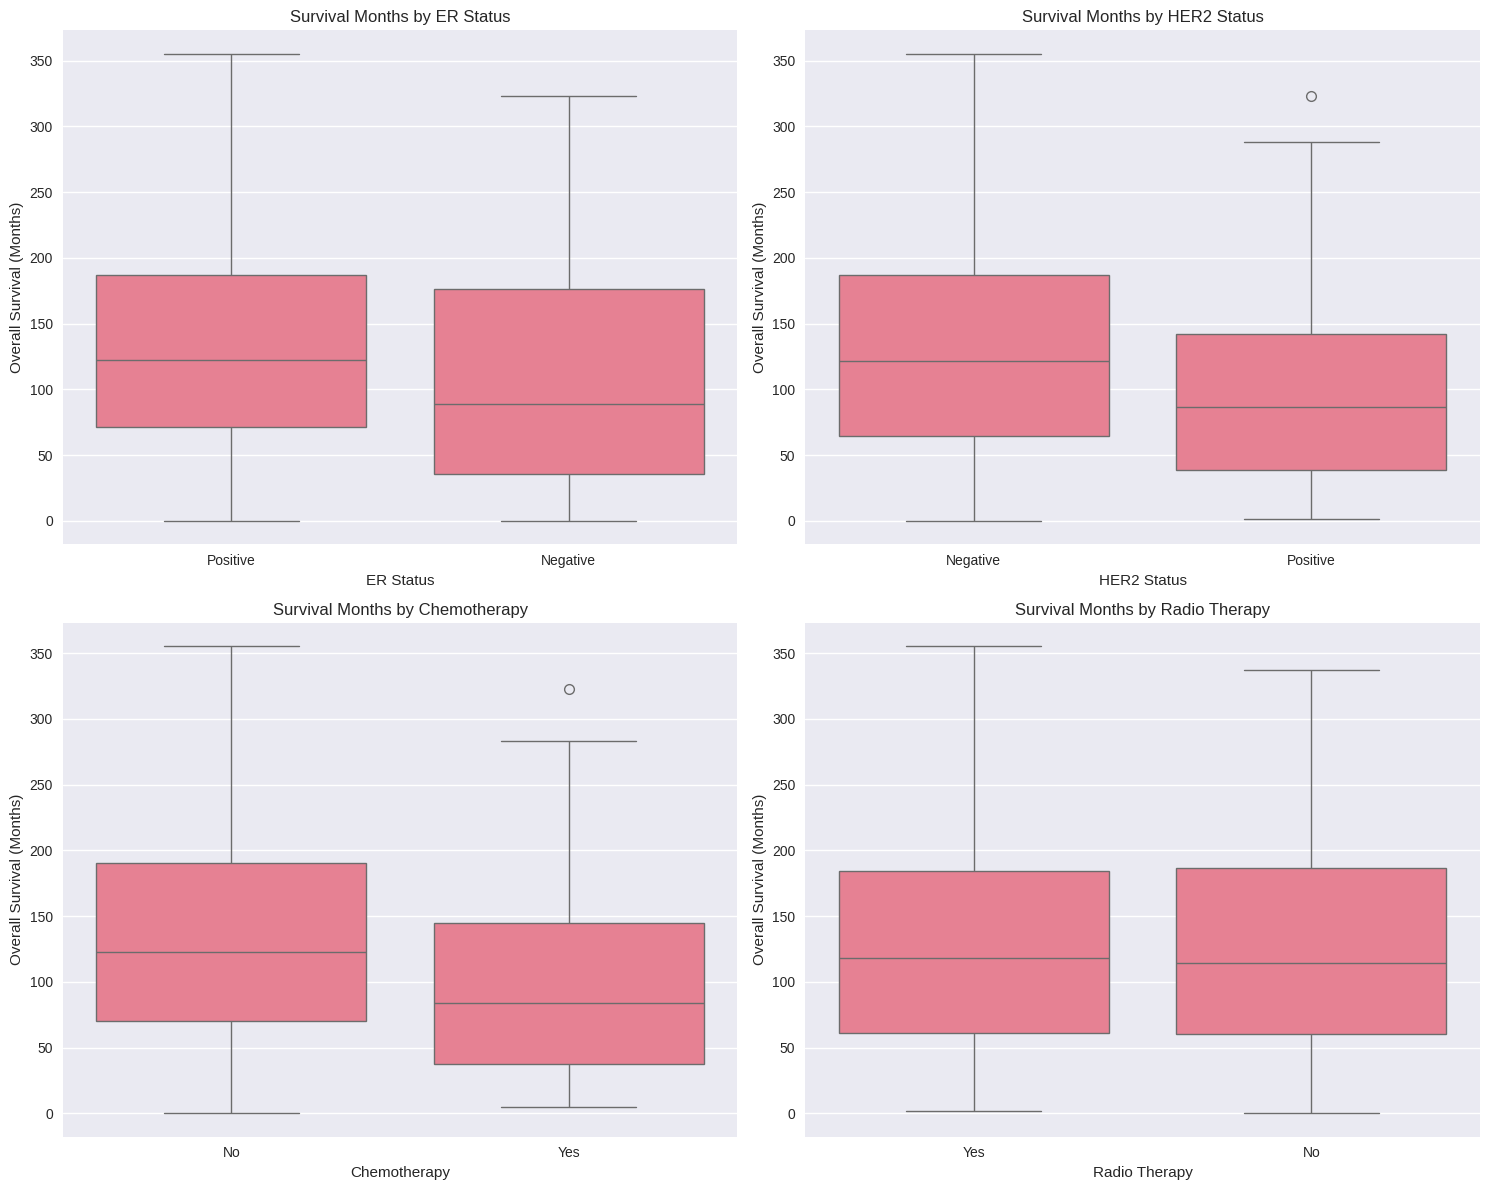

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ER Status vs Survival
sns.boxplot(data=df, x='ER Status', y='Overall Survival (Months)', ax=axes[0,0])
axes[0,0].set_title('Survival Months by ER Status')

# HER2 Status vs Survival
sns.boxplot(data=df, x='HER2 Status', y='Overall Survival (Months)', ax=axes[0,1])
axes[0,1].set_title('Survival Months by HER2 Status')

# Chemotherapy vs Survival
sns.boxplot(data=df, x='Chemotherapy', y='Overall Survival (Months)', ax=axes[1,0])
axes[1,0].set_title('Survival Months by Chemotherapy')

# Radio Therapy vs Survival
sns.boxplot(data=df, x='Radio Therapy', y='Overall Survival (Months)', ax=axes[1,1])
axes[1,1].set_title('Survival Months by Radio Therapy')

plt.tight_layout()
plt.show()

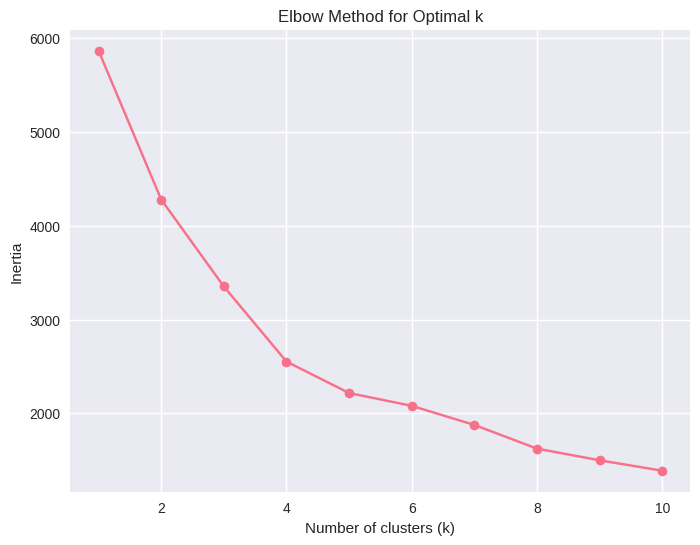

In [53]:

# Prepare data for clustering
cluster_vars = ['Tumor Size', 'Age at Diagnosis', 'Overall Survival (Months)']
cluster_data = df[cluster_vars].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Find optimal number of clusters
inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,6))
plt.plot(range(1,11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

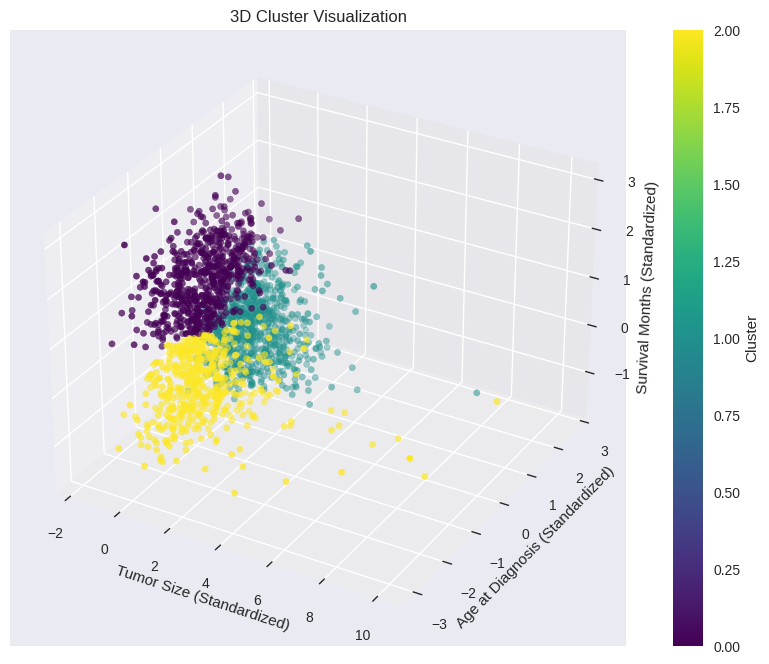

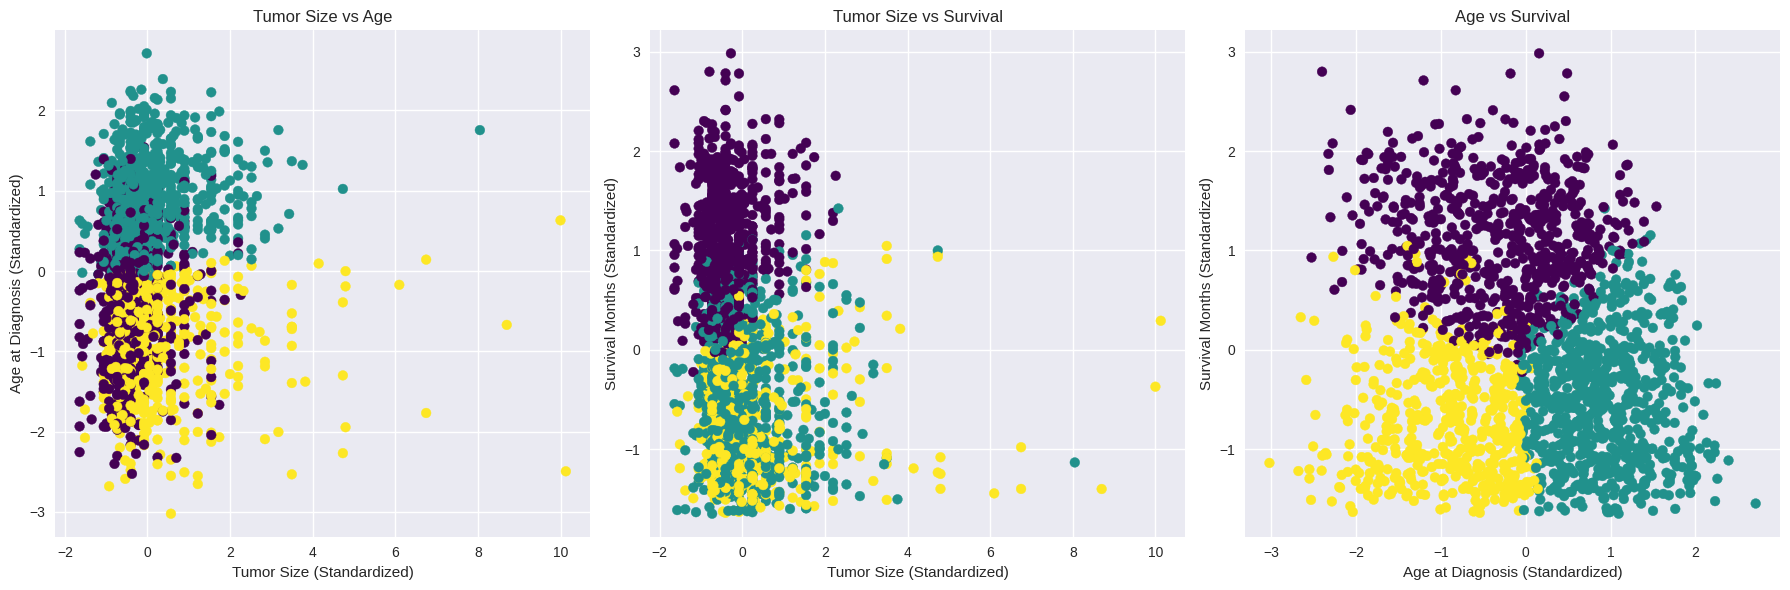


Cluster Statistics:

Cluster 0:
Number of patients: 675

Average values (standardized):
Tumor Size: -0.35
Age: -0.32
Survival: 1.10

Cluster 1:
Number of patients: 762

Average values (standardized):
Tumor Size: 0.12
Age: 0.90
Survival: -0.50

Cluster 2:
Number of patients: 518

Average values (standardized):
Tumor Size: 0.28
Age: -0.91
Survival: -0.70


In [54]:


# Prepare data
cluster_vars = ['Tumor Size', 'Age at Diagnosis', 'Overall Survival (Months)']
cluster_data = df[cluster_vars].dropna()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Let's use 3 clusters based on the elbow curve
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with different colors for each cluster
scatter = ax.scatter(scaled_data[:, 0],
                    scaled_data[:, 1],
                    scaled_data[:, 2],
                    c=clusters,
                    cmap='viridis')

# Add labels
ax.set_xlabel('Tumor Size (Standardized)')
ax.set_ylabel('Age at Diagnosis (Standardized)')
ax.set_zlabel('Survival Months (Standardized)')
plt.colorbar(scatter, label='Cluster')
plt.title('3D Cluster Visualization')
plt.show()

# Let's also create 2D plots for each pair of variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Tumor Size vs Age
axes[0].scatter(scaled_data[:, 0], scaled_data[:, 1], c=clusters, cmap='viridis')
axes[0].set_xlabel('Tumor Size (Standardized)')
axes[0].set_ylabel('Age at Diagnosis (Standardized)')
axes[0].set_title('Tumor Size vs Age')

# Plot Tumor Size vs Survival
axes[1].scatter(scaled_data[:, 0], scaled_data[:, 2], c=clusters, cmap='viridis')
axes[1].set_xlabel('Tumor Size (Standardized)')
axes[1].set_ylabel('Survival Months (Standardized)')
axes[1].set_title('Tumor Size vs Survival')

# Plot Age vs Survival
axes[2].scatter(scaled_data[:, 1], scaled_data[:, 2], c=clusters, cmap='viridis')
axes[2].set_xlabel('Age at Diagnosis (Standardized)')
axes[2].set_ylabel('Survival Months (Standardized)')
axes[2].set_title('Age vs Survival')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
for i in range(3):
    cluster_data = scaled_data[clusters == i]
    print(f"\nCluster {i}:")
    print(f"Number of patients: {len(cluster_data)}")
    print("\nAverage values (standardized):")
    print(f"Tumor Size: {cluster_data[:, 0].mean():.2f}")
    print(f"Age: {cluster_data[:, 1].mean():.2f}")
    print(f"Survival: {cluster_data[:, 2].mean():.2f}")

ok these arent very clustery


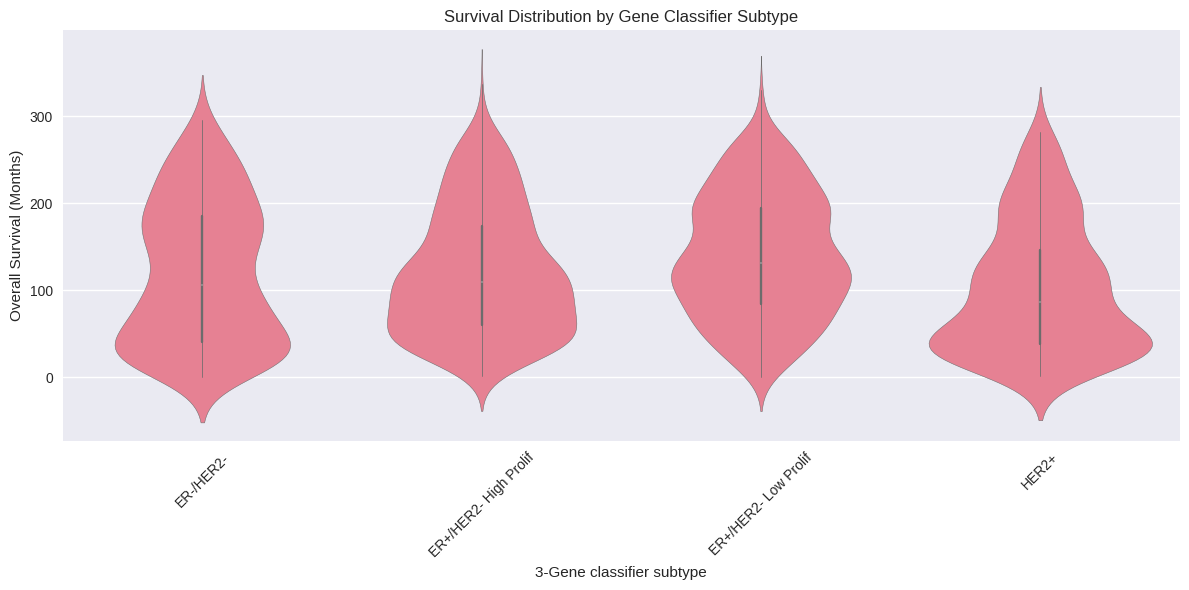

In [55]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x='3-Gene classifier subtype', y='Overall Survival (Months)')
plt.xticks(rotation=45)
plt.title('Survival Distribution by Gene Classifier Subtype')
plt.tight_layout()
plt.show()

**Origionally** I Was only going to train a neural network on the features we had defined. But I started getting very low r^2 values. I think that there is too much variance caused by every feature, so our neural network needs to account for every feature.

[link text](https://)

Final shape of features: (1981, 101)
Final shape of target: (1981,)

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 128)                 │          13,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,409 (161.75 KB)

 Trainable params: 40,929 (159.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 3.2862 - mae: 1.4401 - val_loss: 1.0647 - val_mae: 0.8769
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3678 - mae: 1.2295 - val_loss: 0.9960 - val_mae: 0.8402
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1065 - mae: 1.1581 - val_loss: 0.9562 - val_mae: 0.8243
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7421 - mae: 1.0509 - val_loss: 0.9330 - val_mae: 0.8072
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6661 - mae: 1.0235 - val_loss: 0.9279 - val_mae: 0.7971
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5447 - mae: 0.9870 - val_loss: 0.9288 - val_mae: 0.7949
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4257 - mae: 0.9498 - val_loss: 0.8809 - val_mae: 0.7699
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3116 - mae: 0.9200 - val_loss: 0.8386 - val_mae: 0.7428
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.27

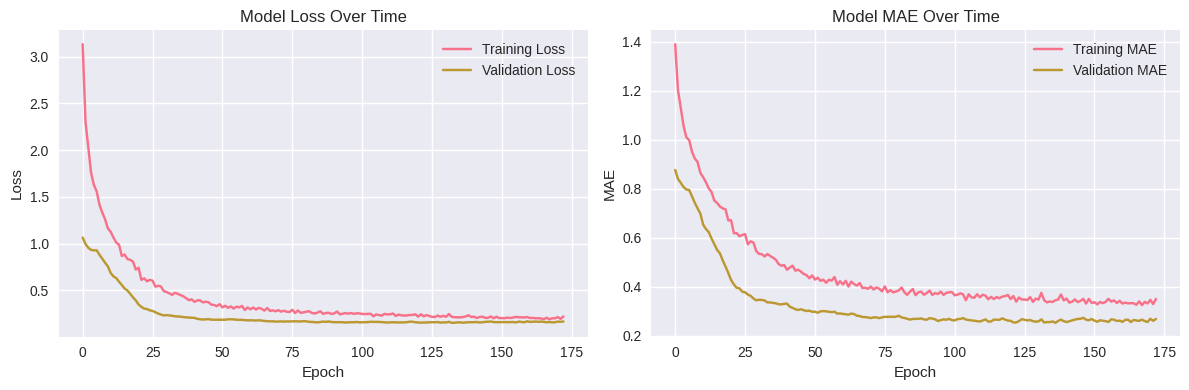

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model Performance:
R² Score: 0.825
Mean Absolute Error: 21.95 months
Root Mean Squared Error: 31.63 months


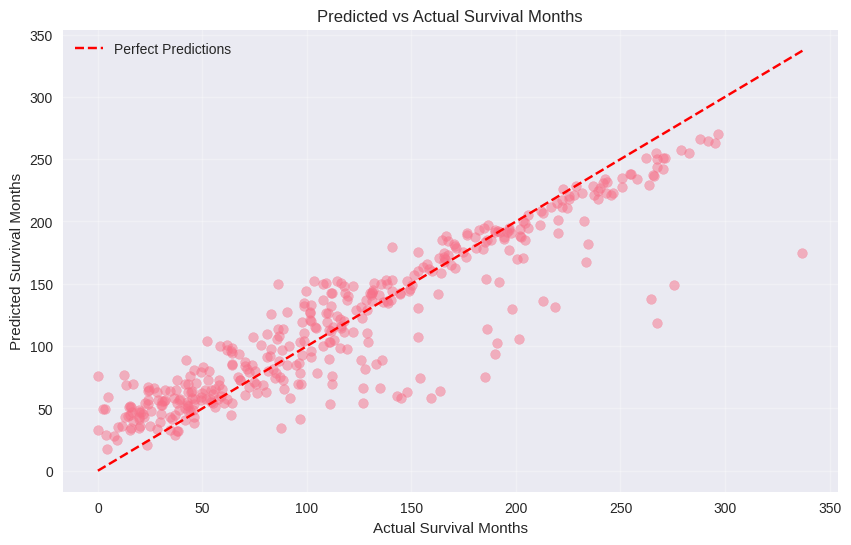

In [56]:

# First, remove features we don't want to use
features_to_drop = [
    'Patient ID',  # Just an identifier
    'Overall Survival Status',  # This would leak information about our target
    'Relapse Free Status',  # Could leak information
    "Patient's Vital Status"  # Related to our target
]

# Separate numeric and categorical features
numeric_features = [
    'Age at Diagnosis',
    'Cohort',
    'Neoplasm Histologic Grade',
    'Lymph nodes examined positive',
    'Mutation Count',
    'Nottingham prognostic index',
    'Relapse Free Status (Months)',
    'Tumor Size',
    'Tumor Stage'
]

categorical_features = [col for col in df.columns if col not in numeric_features + features_to_drop + ['Overall Survival (Months)']]

# Create clean copy of the data
df_model = df.drop(columns=features_to_drop)

# Handle numeric features
numeric_imputer = SimpleImputer(strategy='median')
X_numeric = pd.DataFrame(
    numeric_imputer.fit_transform(df_model[numeric_features]),
    columns=numeric_features
)

# Handle categorical features
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
X_categorical_imputed = pd.DataFrame(
    categorical_imputer.fit_transform(df_model[categorical_features]),
    columns=categorical_features
)

# One-hot encode categorical features
onehot = OneHotEncoder(handle_unknown='ignore')
X_categorical = onehot.fit_transform(X_categorical_imputed).toarray()

# Get feature names after one-hot encoding
categorical_feature_names = []
for i, feature in enumerate(categorical_features):
    feature_names = [f"{feature}_{val}" for val in onehot.categories_[i]]
    categorical_feature_names.extend(feature_names)

# Combine features
X_combined = np.hstack([X_numeric, X_categorical])

# Prepare target variable
y = df_model['Overall Survival (Months)'].copy()
mask = y.notna()  # Keep track of non-missing target values

# Only keep rows where we have the target variable
X_combined = X_combined[mask]
y = y[mask]

print("Final shape of features:", X_combined.shape)
print("Final shape of target:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Create a deeper network
model = Sequential([
    # First block - wide input layer
    Dense(128, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.4),

    # Second block
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third block
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Fourth block
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    # Output layer
    Dense(1, activation='linear')
])

# Compile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

print("\nModel Architecture:")
model.summary()

# Train with more patience
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Make predictions and evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f} months")
print(f"Root Mean Squared Error: {rmse:.2f} months")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--',
         label='Perfect Predictions')
plt.xlabel('Actual Survival Months')
plt.ylabel('Predicted Survival Months')
plt.title('Predicted vs Actual Survival Months')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

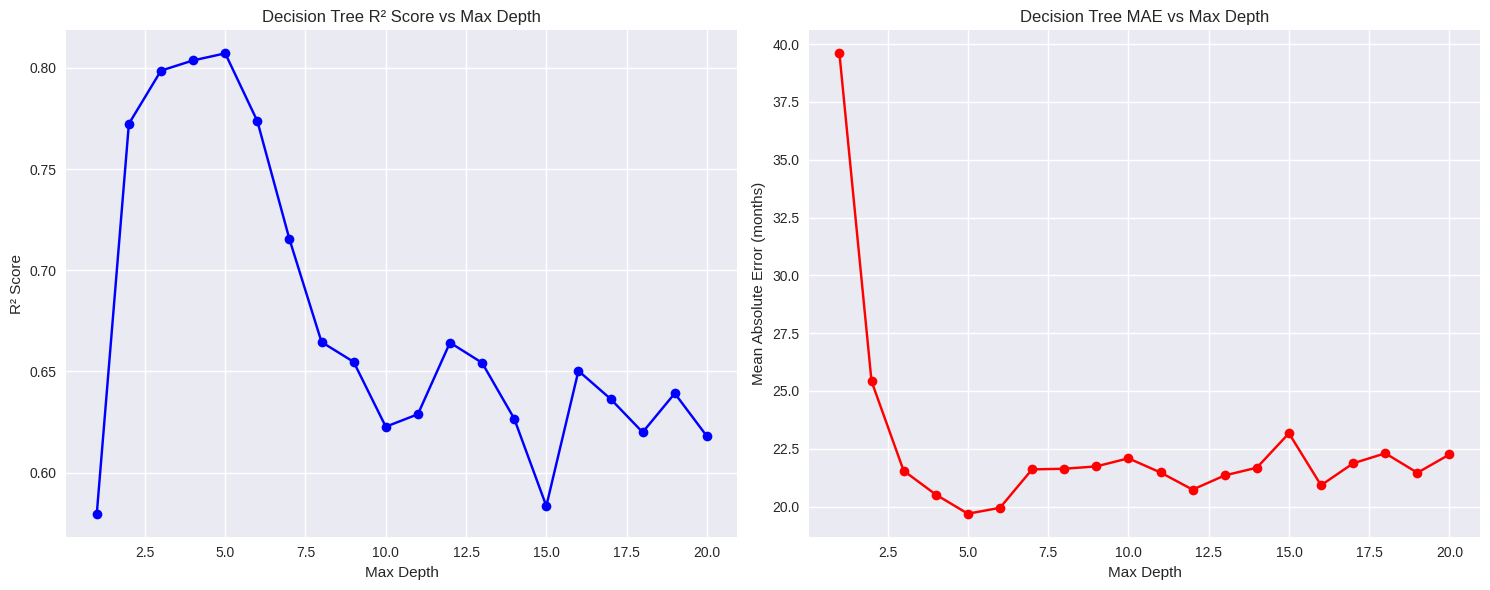


Best depth: 5
Best R² score: 0.8072
MAE at best depth: 19.69 months

Model Performance Comparison:

Random Forest:
R² Score: 0.8239
MAE: 19.08 months

Best Decision Tree:
R² Score: 0.8072
MAE: 19.69 months


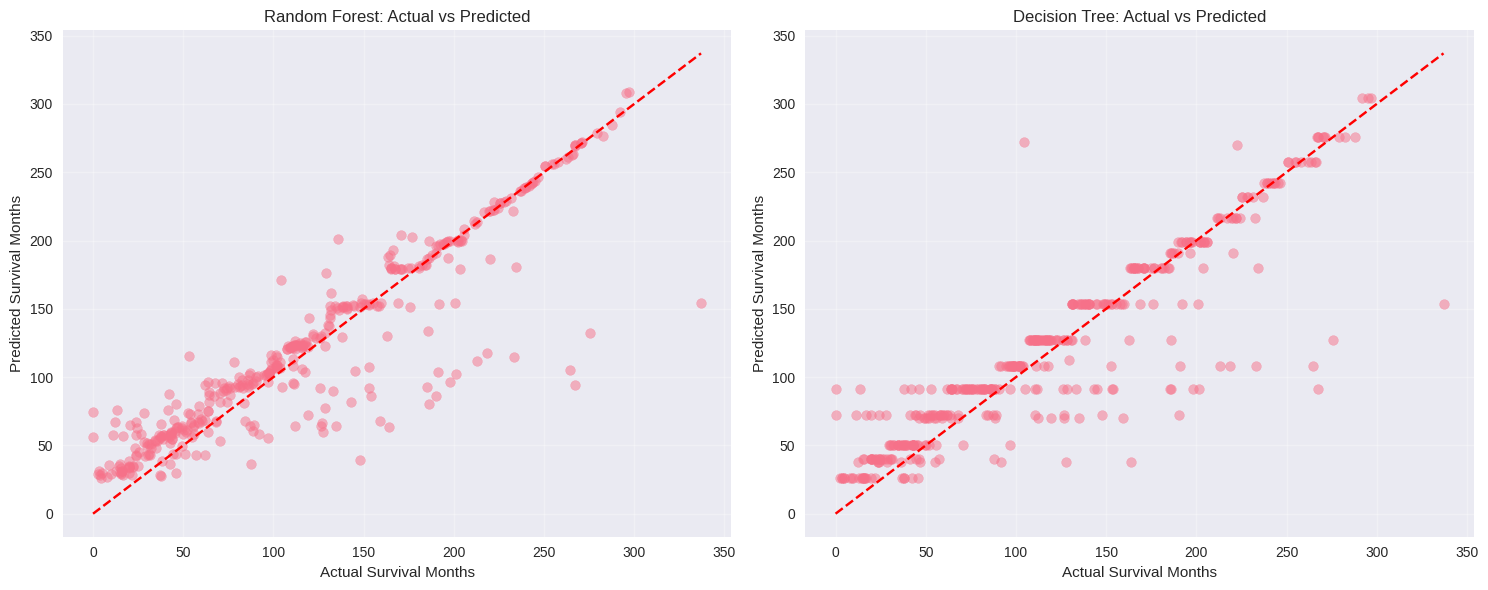

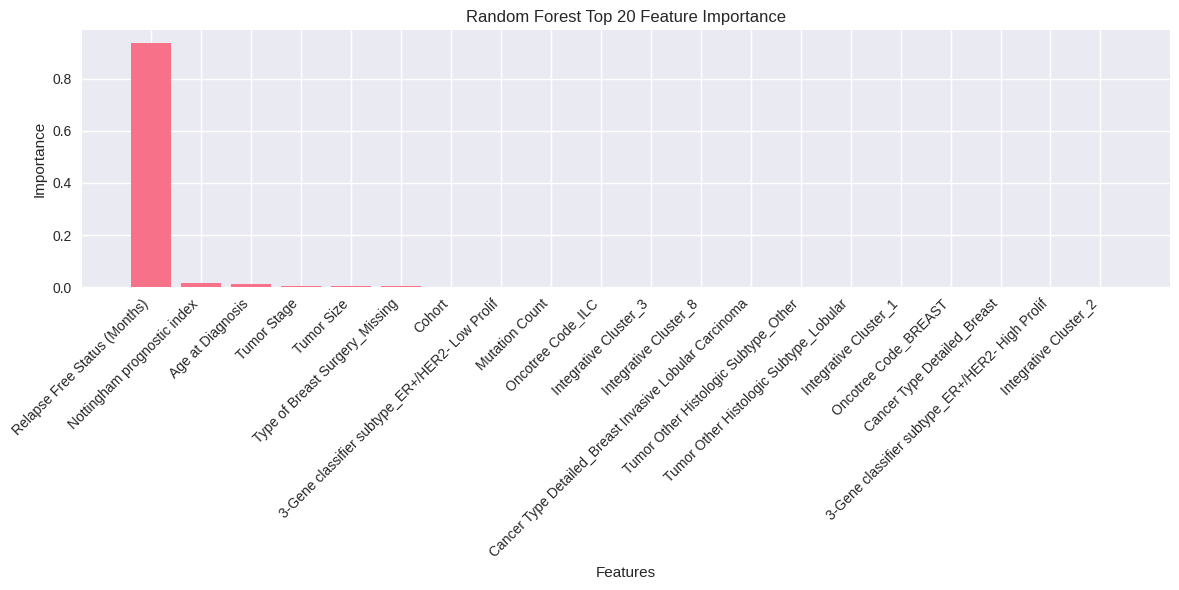

In [57]:

# Test different depths
max_depths = range(1, 21)  # Test depths from 1 to 20
dt_scores = []
dt_mae_scores = []

for depth in max_depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt.fit(X_train_scaled, y_train)  # Using scaled features like in neural network
    score = dt.score(X_test_scaled, y_test)
    dt_scores.append(score)

    # Calculate MAE
    y_pred = dt.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    dt_mae_scores.append(mae)

# Plot decision tree performance vs depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# R² Score plot
ax1.plot(max_depths, dt_scores, 'bo-')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('R² Score')
ax1.set_title('Decision Tree R² Score vs Max Depth')
ax1.grid(True)

# MAE plot
ax2.plot(max_depths, dt_mae_scores, 'ro-')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Mean Absolute Error (months)')
ax2.set_title('Decision Tree MAE vs Max Depth')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find best depth based on R² score
best_depth = max_depths[np.argmax(dt_scores)]
print(f"\nBest depth: {best_depth}")
print(f"Best R² score: {max(dt_scores):.4f}")
print(f"MAE at best depth: {dt_mae_scores[np.argmax(dt_scores)]:.2f} months")

# Create models with best depth
best_dt = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=best_depth, random_state=42)

# Train models
best_dt.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Make predictions
dt_predictions = best_dt.predict(X_test_scaled)
rf_predictions = rf.predict(X_test_scaled)

# Compare performance
print("\nModel Performance Comparison:")
print("\nRandom Forest:")
print(f"R² Score: {r2_score(y_test, rf_predictions):.4f}")
print(f"MAE: {mean_absolute_error(y_test, rf_predictions):.2f} months")

print("\nBest Decision Tree:")
print(f"R² Score: {r2_score(y_test, dt_predictions):.4f}")
print(f"MAE: {mean_absolute_error(y_test, dt_predictions):.2f} months")

# Plot actual vs predicted values for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest plot
ax1.scatter(y_test, rf_predictions, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_xlabel('Actual Survival Months')
ax1.set_ylabel('Predicted Survival Months')
ax1.set_title('Random Forest: Actual vs Predicted')
ax1.grid(True, alpha=0.3)

# Decision Tree plot
ax2.scatter(y_test, dt_predictions, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_xlabel('Actual Survival Months')
ax2.set_ylabel('Predicted Survival Months')
ax2.set_title('Decision Tree: Actual vs Predicted')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for Random Forest
# Combine numeric and one-hot encoded feature names
feature_names = numeric_features + categorical_feature_names

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.bar(range(20), feature_importance['importance'][:20])
plt.xticks(range(20), feature_importance['feature'][:20], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Top 20 Feature Importance')
plt.tight_layout()
plt.show()

Im going to try some more machine learning models


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 2007, number of used features: 26
[LightGBM] [Info] Start training from score -2.825273
[LightGBM] [Info] Start training from score -2.362649
[LightGBM] [Info] Start training from score -2.504530
[LightGBM] [Info] Start training from score -0.589582
[LightGBM] [Info] Start training from score -1.559391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

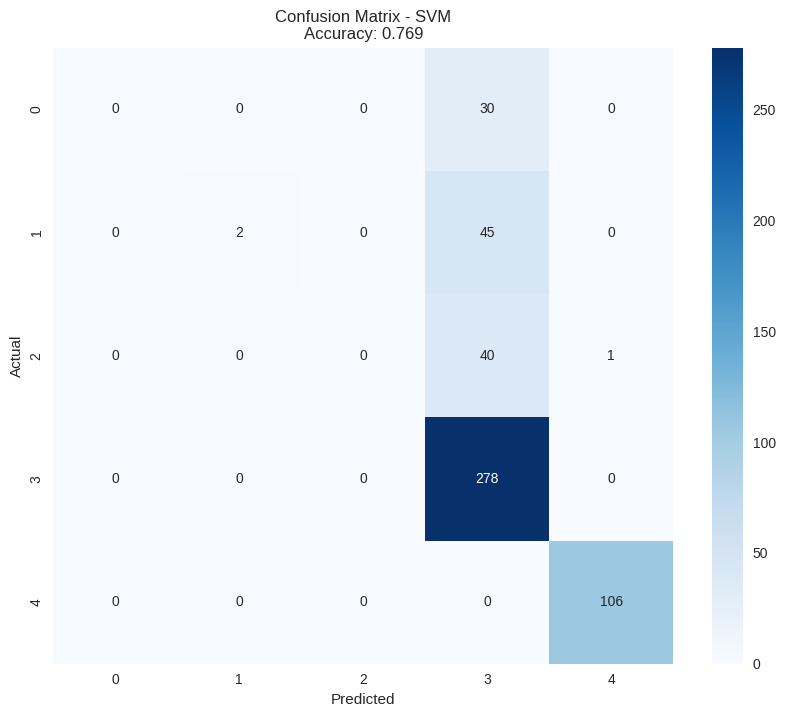

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

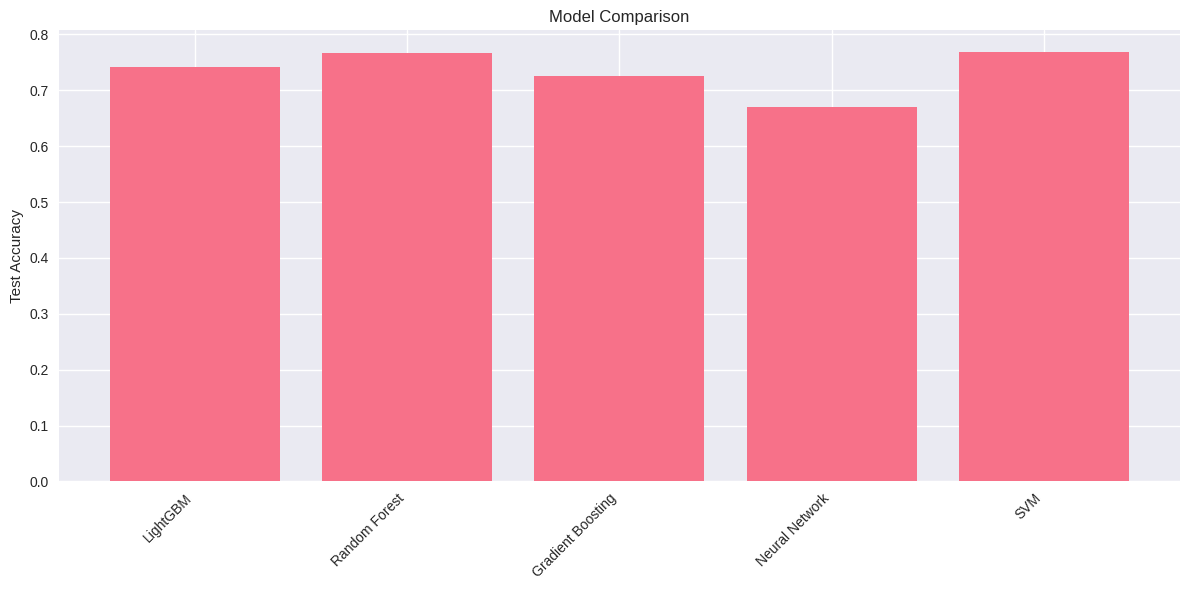


Misclassification Analysis for SVM:
Total misclassified samples: 116
Misclassification rate: 23.11%


In [59]:

warnings.filterwarnings('ignore')

# Get features we want to use
features_to_drop = [
    'Patient ID',
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Relapse Free Status',
    'Relapse Free Status (Months)',
    "Patient's Vital Status"
]

# Create clean copy
df_clean = df.copy()

# Create survival categories using custom bins
survival_bins = [0, 24, 48, 72, float('inf')]  # 2-year intervals
survival_labels = ['0-2 years', '2-4 years', '4-6 years', '6+ years']
df_clean['Survival_Category'] = pd.cut(
    df_clean['Overall Survival (Months)'],
    bins=survival_bins,
    labels=survival_labels,
    include_lowest=True
)

# Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

# Remove unwanted features
numeric_cols = [col for col in numeric_cols if col not in features_to_drop]
categorical_cols = [col for col in categorical_cols if col not in features_to_drop + ['Survival_Category']]

# Fill numeric missing values with median
for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Fill categorical missing values with mode
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Encode categorical variables
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    df_clean[col] = encoders[col].fit_transform(df_clean[col])

# Prepare features and target
X = df_clean[list(numeric_cols) + list(categorical_cols)]
y = LabelEncoder().fit_transform(df_clean['Survival_Category'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'LightGBM': LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=1000,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    results[name] = {
        'train_acc': accuracy_score(y_train, train_pred),
        'test_acc': accuracy_score(y_test, test_pred),
        'predictions': test_pred,
        'classification_report': classification_report(y_test, test_pred)
    }

    # Print results
    print(f"Training Accuracy: {results[name]['train_acc']:.4f}")
    print(f"Testing Accuracy: {results[name]['test_acc']:.4f}")
    print("\nClassification Report:")
    print(results[name]['classification_report'])

# Find best model
best_model = max(results.items(), key=lambda x: x[1]['test_acc'])
print(f"\nBest model: {best_model[0]}")

# Plot confusion matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_model[1]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model[0]}\nAccuracy: {best_model[1]["test_acc"]:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance for best model (if applicable)
if hasattr(models[best_model[0]], 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': models[best_model[0]].feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(20), importance['importance'][:20])
    plt.xticks(range(20), importance['feature'][:20], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

# Cross-validation for all models
print("\nCross-validation scores:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"\n{name}:")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Plot model comparison
plt.figure(figsize=(12, 6))
accuracies = {name: metrics['test_acc'] for name, metrics in results.items()}
plt.bar(accuracies.keys(), accuracies.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()

# Analysis of misclassifications
best_model_name = best_model[0]
misclassified = y_test != best_model[1]['predictions']
misclassified_indices = np.where(misclassified)[0]

print(f"\nMisclassification Analysis for {best_model_name}:")
print(f"Total misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {(misclassified.sum() / len(y_test)):.2%}")

Im going to try several permutations of features and models to find the best ones.


Processing feature set: clinical
Training Random Forest...
Accuracy: 0.7092
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        41
           3       0.70      0.90      0.79       278
           4       0.72      1.00      0.84       106

    accuracy                           0.71       502
   macro avg       0.29      0.38      0.33       502
weighted avg       0.54      0.71      0.61       502

Training Gradient Boosting...
Accuracy: 0.7131
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.40      0.04      0.08        47
           2       0.00      0.00      0.00        41
           3       0.72      0.90      0.80       278
           4       0.72      1.00      0.84       106

    accuracy   

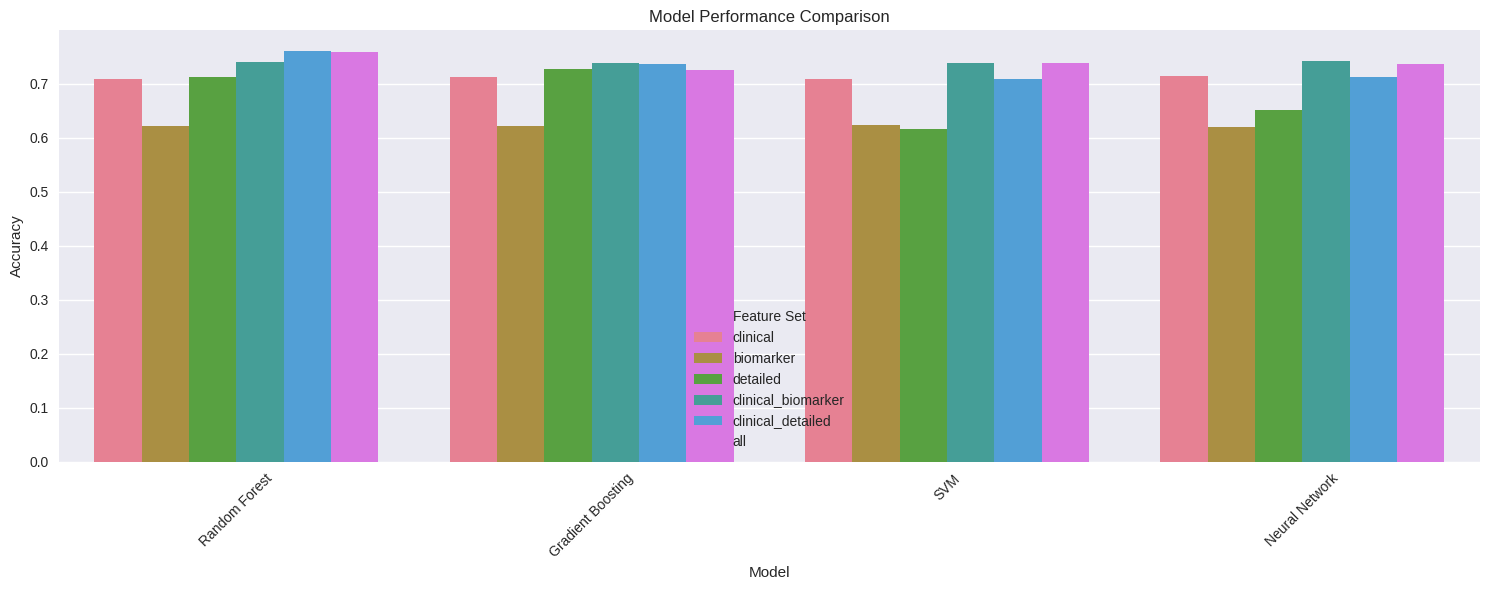

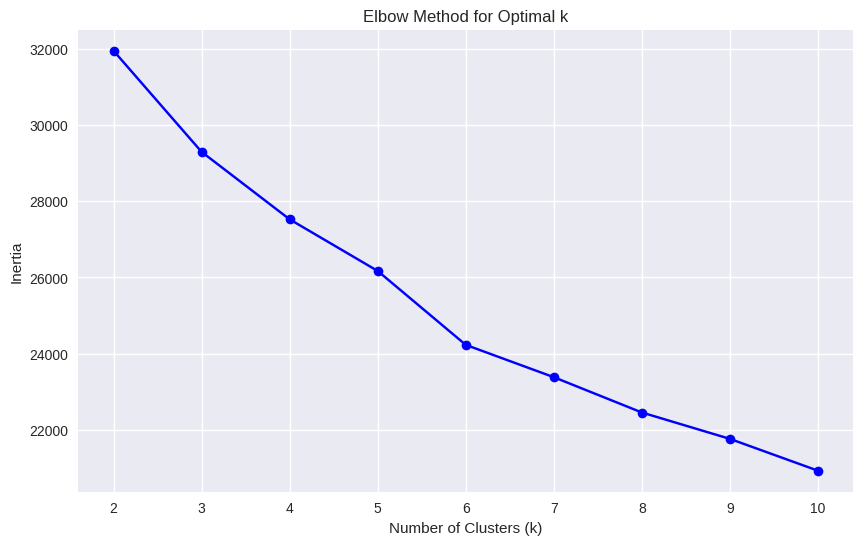

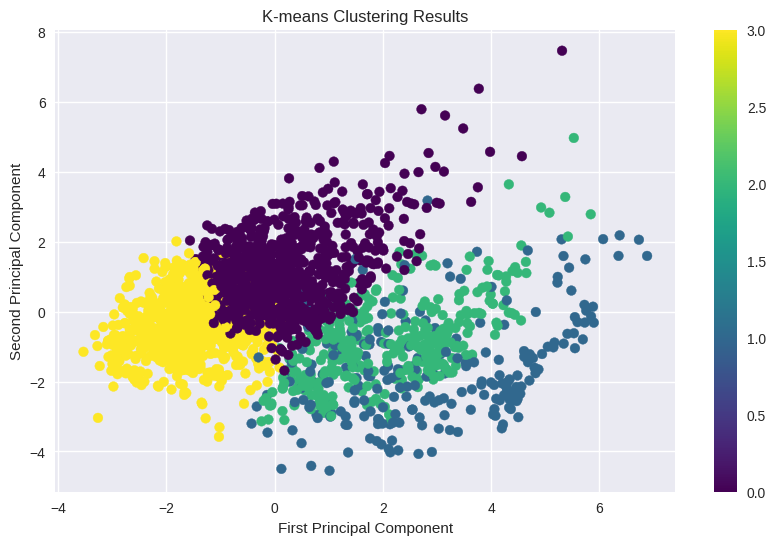

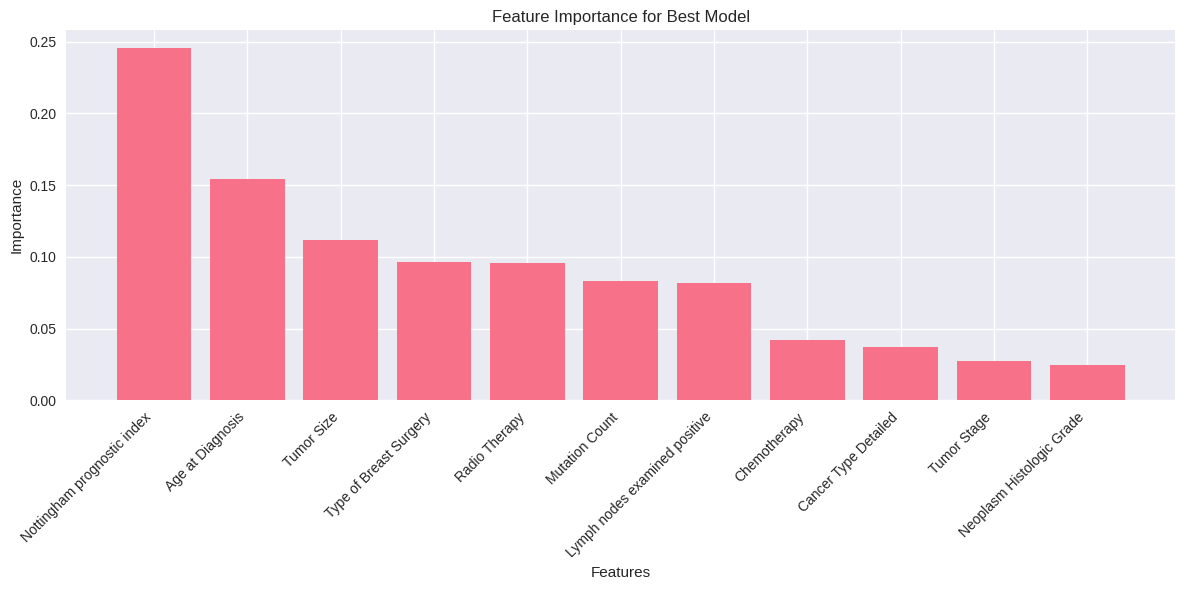

In [60]:

warnings.filterwarnings('ignore')

# First, let's create different feature sets
features_to_drop = [
    'Patient ID',
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Relapse Free Status',
    'Relapse Free Status (Months)',
    "Patient's Vital Status"
]

# Create different feature combinations
def get_feature_sets(df):
    clinical_features = [
        'Age at Diagnosis',
        'Tumor Size',
        'Tumor Stage',
        'Type of Breast Surgery',
        'Chemotherapy',
        'Radio Therapy'
    ]

    biomarker_features = [
        'ER Status',
        'PR Status',
        'HER2 Status',
        '3-Gene classifier subtype'
    ]

    detailed_features = [
        'Cancer Type Detailed',
        'Neoplasm Histologic Grade',
        'Lymph nodes examined positive',
        'Mutation Count',
        'Nottingham prognostic index'
    ]

    feature_sets = {
        'clinical': clinical_features,
        'biomarker': biomarker_features,
        'detailed': detailed_features,
        'clinical_biomarker': clinical_features + biomarker_features,
        'clinical_detailed': clinical_features + detailed_features,
        'all': clinical_features + biomarker_features + detailed_features
    }

    return feature_sets

# Prepare data with different feature sets
def prepare_data(df, features):
    df_clean = df.copy()

    # Create survival categories using custom bins
    survival_bins = [0, 24, 48, 72, float('inf')]  # 2-year intervals
    survival_labels = ['0-2 years', '2-4 years', '4-6 years', '6+ years']
    df_clean['Survival_Category'] = pd.cut(
        df_clean['Overall Survival (Months)'],
        bins=survival_bins,
        labels=survival_labels,
        include_lowest=True
    )

    # Handle missing values
    numeric_features = df_clean[features].select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df_clean[features].select_dtypes(include=['object']).columns

    for col in numeric_features:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    for col in categorical_features:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

    # Encode categorical variables
    encoders = {}
    for col in categorical_features:
        encoders[col] = LabelEncoder()
        df_clean[col] = encoders[col].fit_transform(df_clean[col])

    # Prepare features and target
    X = df_clean[features]
    y = LabelEncoder().fit_transform(df_clean['Survival_Category'])

    return X, y

# Model configurations
def get_models():
    models = {
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 15],
                'min_samples_split': [2, 5, 10]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5]
            }
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }
        },
        'Neural Network': {
            'model': MLPClassifier(random_state=42, max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 25)],
                'learning_rate_init': [0.001, 0.01],
                'alpha': [0.0001, 0.001]
            }
        }
    }
    return models

# Train and evaluate models
def train_and_evaluate(X, y, model_name, model, params):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Grid search for best parameters
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return {
        'model_name': model_name,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'report': report,
        'best_model': best_model
    }

# Main execution
feature_sets = get_feature_sets(df)
models = get_models()

# Store results
results = []

# Train and evaluate each model with each feature set
for feature_set_name, features in feature_sets.items():
    print(f"\nProcessing feature set: {feature_set_name}")
    X, y = prepare_data(df, features)

    for model_name, model_info in models.items():
        print(f"Training {model_name}...")
        result = train_and_evaluate(X, y, model_name, model_info['model'], model_info['params'])
        result['feature_set'] = feature_set_name
        results.append(result)
        print(f"Accuracy: {result['accuracy']:.4f}")
        print("Classification Report:")
        print(result['report'])

# Find best model
best_result = max(results, key=lambda x: x['accuracy'])
print("\nBest Model:")
print(f"Model: {best_result['model_name']}")
print(f"Feature Set: {best_result['feature_set']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print("Best Parameters:", best_result['best_params'])
print("\nClassification Report:")
print(best_result['report'])

# Plot results
plt.figure(figsize=(15, 6))
results_df = pd.DataFrame([(r['model_name'], r['feature_set'], r['accuracy'])
                          for r in results],
                         columns=['Model', 'Feature Set', 'Accuracy'])

sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Feature Set')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

# Try clustering as well
X, y = prepare_data(df, feature_sets['all'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Try different numbers of clusters
inertias = []
n_clusters_range = range(2, 11)
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Fit KMeans with optimal number of clusters (from elbow curve)
optimal_k = 4  # This should be chosen based on the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clustering Results')
plt.colorbar(scatter)
plt.show()

# Additional analysis for the best model
best_model = best_result['best_model']
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_sets[best_result['feature_set']],
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importance)), feature_importance['importance'])
    plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance for Best Model')
    plt.tight_layout()
    plt.show()

Im going to try an approach based on survival modeling - as that is what we are fundementally doing. Deepsurv is a deep learning model that is based in survival analysis

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 - val_c_index: 0.5797
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 5054002.5000 - val_loss: 217237.1719 - learning_rate: 0.0010 - val_c_index: 0.5797
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
 - val_c_index: 0.6112
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4951082.5000 - val_loss: 217159.0156 - learning_rate: 0.0010 - val_c_index: 0.6112
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 - val_c_index: 0.6275
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - loss: 4900356.5000 - val_loss: 217114.8906 - learning_rate: 0.0010 - val_c_index: 0.6275
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
 - val_c_index: 0.6353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 4838750.5000 - val_loss: 217134.2344 - learning_rate: 0.0010 - val_c_index: 0.6353
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
 - val_c_index: 0.6333
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4816085.0000 - val_loss: 217159.4062 - learning_rate: 0.0010 - va

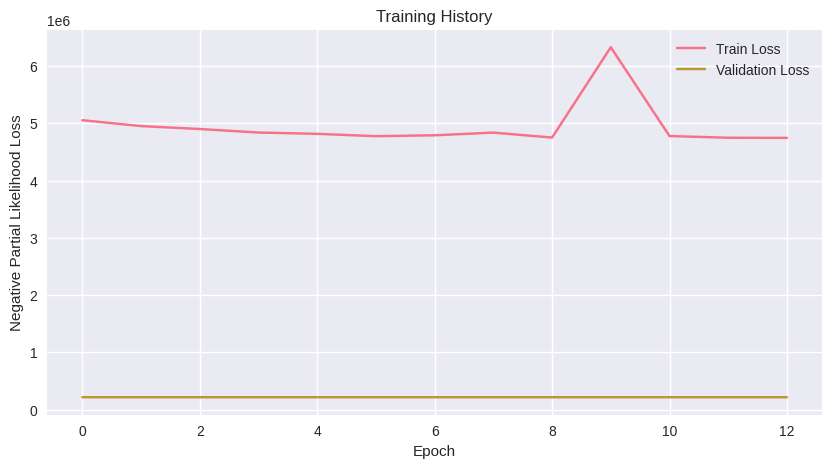

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Final Validation Concordance Index (C-index): 0.6275


In [43]:

df = pd.read_csv("Breast Cancer METABRIC.csv")

# Select a set of features (modify as appropriate)
features = ['Age at Diagnosis', 'Tumor Size', 'Nottingham prognostic index', 'Tumor Stage']
df = df.dropna(subset=features + ['Overall Survival (Months)', 'Overall Survival Status'])

# Create X (features)
X = df[features]

# Create survival target y: first column is time, second is event indicator.
df['event'] = df['Overall Survival Status'].apply(lambda x: 1 if ('deceased' in x.lower() or 'died' in x.lower()) else 0)
y_time = df['Overall Survival (Months)'].values
y_event = df['event'].values
y = np.vstack([y_time, y_event]).T

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# -----------------------------
# 2. Define the Custom Cox Partial Likelihood Loss
# -----------------------------
def cox_ph_loss(y_true, y_pred):
    """
    Approximates the negative log partial likelihood for the Cox model.
    Assumes y_true shape: (batch, 2) where y_true[:, 0] = time, y_true[:, 1] = event indicator.
    """
    # Extract time and event indicators
    time = y_true[:, 0]
    event = y_true[:, 1]

    # Sort by descending time (for risk set computation)
    order = tf.argsort(time, direction='DESCENDING')
    sorted_time = tf.gather(time, order)
    sorted_event = tf.gather(event, order)
    sorted_y_pred = tf.gather(y_pred, order)

    # Compute the cumulative sum in the risk set using log-sum-exp for stability
    exp_pred = tf.exp(sorted_y_pred)
    cum_sum = tf.cumsum(exp_pred)

    # Log likelihood for each event: risk score minus log(cumulated risk)
    log_likelihood = sorted_y_pred - tf.math.log(cum_sum + 1e-8)
    # Only count events
    event_loss = log_likelihood * tf.cast(sorted_event, dtype=tf.float32)
    loss = -tf.reduce_sum(event_loss)
    return loss

# -----------------------------
# 3. Define a Custom Callback to Compute the C-index
# -----------------------------
class CIndexCallback(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Predict risk scores on the validation set
        risk_scores = self.model.predict(self.X_val).flatten()
        # In survival analysis, a higher risk score means higher risk (shorter survival)
        # For the concordance_index, we pass -risk_scores so that higher predicted survival is "better."
        c_index = concordance_index(self.y_val[:, 0], -risk_scores, self.y_val[:, 1])
        logs = logs or {}
        logs['val_c_index'] = c_index
        print(f" - val_c_index: {c_index:.4f}")

# -----------------------------
# 4. Build the Improved DeepSurv Model
# -----------------------------
input_shape = X_train.shape[1]
inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(x)
# Optional: x = layers.BatchNormalization()(x)

outputs = layers.Dense(1, activation=None)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

# -----------------------------
# 5. Compile and Train the Model with Callbacks
# -----------------------------
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=cox_ph_loss)

# Callbacks: Reduce LR on plateau and early stopping
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    CIndexCallback(validation_data=(X_val, y_val))
]

# For accurate risk-set computation, we train with full batch (or use a custom mini-batch strategy)
full_batch_size = X_train.shape[0]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=full_batch_size,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 6. Plot Training History and Evaluate the Model
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Partial Likelihood Loss')
plt.title('Training History')
plt.legend()
plt.show()

# Compute final C-index on validation set
risk_scores_val = model.predict(X_val).flatten()
final_c_index = concordance_index(y_val[:, 0], -risk_scores_val, y_val[:, 1])
print("Final Validation Concordance Index (C-index): {:.4f}".format(final_c_index))
